In this project, we will examine the effect of an imbalanced dataset. 
We will expore the data with EDA using Pandas-Profiling and scatterpolts.
Firstly, we will run a random forest model with imbalanced target variable.
Then, we will perfrom the SMOTE (Synthetic Minority Over-Sampling) and Near Miss technique to balance the target variable and run the same model.
Throughout the process, confusion matrix, precision scores and recalling scores will be used to examine the model performace. We will go into the details later.

The dataset is downloaded from [Kaggle](https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star) containing the sample pulsar candidates collected. By [Universe Today](https://www.universetoday.com/25376/pulsars/), "the PULSAR stars are known as the 'lighthouses' - rotating neutron stars that emit a focused beam of electromagnetic radiation that is only visible if you’re standing in it’s [sic] path". 

In the dataset, there are 8 continuous variables and one binary target variable with two classes. 
<br>
- class 1: real pulsar star
- class 0: fake pulsar star (spurious examples caused by RFI/noise)

The mean, standard deviation, excess kurtosis and skewness of the integrated profile are the statistics obtained from the integrated pulse profile describing a longitude-resolved version of the signal that has been averaged in both time and frequency. 

In [2]:
# import 
import pandas_profiling
import pandas as pd
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier #for random forest
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold #for cv
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


#from sklearn.tree import export_graphviz #for visulaization
#import io

In [3]:
# load in data
star = pd.read_csv("/Users/yunatan38/Documents/Projects/PULSAR star prediction/pulsar_stars.csv")

### Exploratory Data Analysis

In [6]:
pandas_profiling.ProfileReport(star)

Number of variables,9
Number of observations,17898
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,72.0 B
Numeric,6
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,2


We see that the target class is imbalanced (16,259 vs 1,639). Training on imbalanced variable ignores the minority class. As a result, we can use either: 1) the SMOTE or 2) near miss to balance the two classes. Additionally, there are correlation of skewness of the integrated profile with excess kurtosis of the integrated profile and correlation of skewness of the DM-SNR curve with excess kurtosis of the DM-SNR curve. In order to determine which method we will use to predict the target variable, let's look at these correlations.

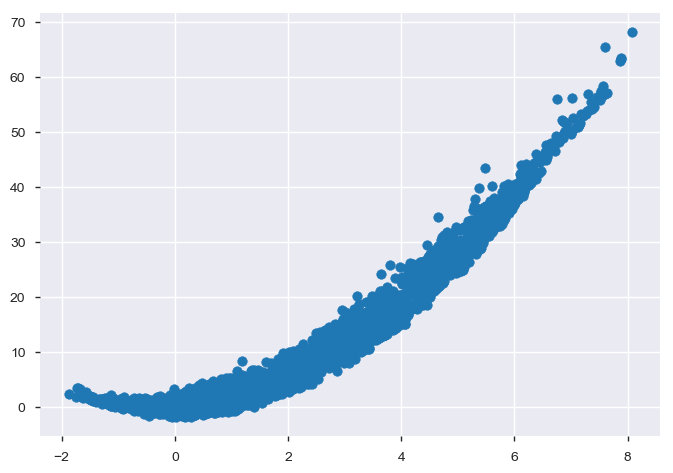

In [7]:
# scatter plot for correlated variables, 
# Skewness of the integrated profile and Excess kurtosis of the integrated profile
plt.scatter(star[[" Excess kurtosis of the integrated profile"]], 
            star[[" Skewness of the integrated profile"]])

The correlation of skewness of the integrated profile with excess kurtosis of the integrated profile does not appear linear.

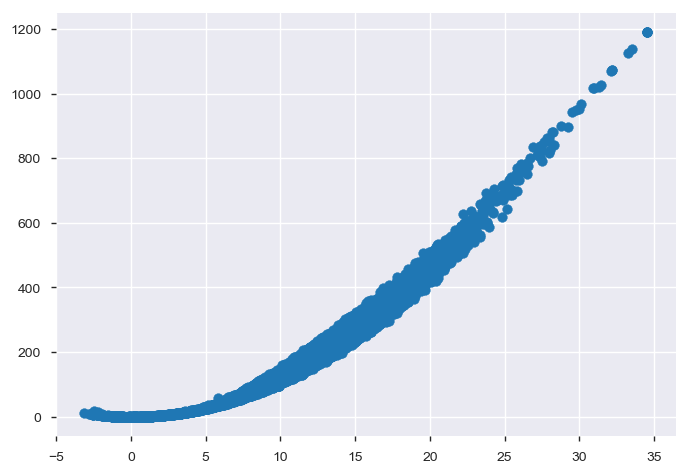

In [8]:
# scatter plot for correlated variables, 
# Excess kurtosis of the DM-SNR curve and Skewness of the DM-SNR curve
plt.scatter(star[[" Excess kurtosis of the DM-SNR curve"]], 
            star[[" Skewness of the DM-SNR curve"]])

Similarily, the correlation of excess kurtosis of the DM-SNR curve with skewness of the DM-SNR curve does not appear linear either. We will use random forest to predict pulsar star by selecting random samples from the training set. In random forest, we first draw a boostrap sample. Then we will repeat the following steps recursively at each node until the minimum node size is reached:

> 1. each time a split in a tree is considered, select m features as split candidates randomly
> 2. pick the best variable and split point among the m features
> 3. split that node into two daughter nodes

A decision tree is constructed on each sample for predictor, and a vote is performed on each prediction. The final prediction is selected from the results with the most votes. Since we are interested in prediction and the random forest model exmaines one predictor candidate at a time, the correlation between variables are not problematic here - thanks for the decorrelation property of the random forest. However, if we were interested in feature importance, then we cannot completely ignore these collinearities, because for instance, if excess kurtosis of the DM-SNR curve is very important then the skewness of the DM-SNR curve is also very important.

<br>

To tune the hyperparameters (explained below), we can use one of the following options:
* Grid search
* Random search
* Bayesian optimization

For a Random Forest model, tuning the hyperparameters using the grid search could be inefficient in terms of processing time becasue grid search runs each possible hyperparameter combinations automatically in a loop. Random search is a good alternative as it only selects the random combinations of the hyperparameters instead of running all of the combinations, which reduces the processing time. However, both of the grid search and random search do not choose the next hyperparameters to evaluate based on the previous results. As a result, both methods are computationally expensive as they spend a lot of time evaluating on hyperparameters that are 'bad'.

For this project, we will use the **bayesian optimization** to tune the hyperparameters. This is achieved by the following steps.

1. **search space**: bayesian optimization operates along probability distributions for each hyperparameter that it will sample from. The random forest hyperparameters follows the type of gradient boosting technique that consists of a list of categories. As a result, we will use the built-in hp.choice function.
<br>
2. **objective function**: this serves a the main evaluator of the hyperparameter combination by taking a set of parameters, training the random forest classifier, and returning a cross validation score that indicates how well the set of hyperparameters perfrom on the validation set. 
<br>
3. **Surrogate function and selection function**:

The hyperparameters we are tuning are:

* **n_estimators**: it represents the number of trees in the forest. The higher the number of trees, the better to learn the data. However, adding too many trees slows down the trianing process. 

* **max_depths**: it represents the depth of each tree in the forest. The deeper the tree, the more splits it has, capturing more information about the data. 

* **min_sample_split**: it represents the minimum number of samples required to split an internal node. As this parameter increases, each tree in the forest becomes more constrained becasue it has too consider more samples at each node.

* **min_sample_leaf**: it represents the minimum number of samples required to be at a leaf node (the base of the tree).

* **max_features**: it represents the number of features to consider when looking for the best split

* **criterion**: for this classification problem, we will consider using either gini or entropy as 

In order to show why imabalanced dataset yields inconclusive resulst, firstly, let's work with the original imbalanced dataset. To begin with, let's split the dataset into the training set and the testing set using 10-fold cross validation. 

In [25]:
# Split the dataset into training and testing using 10-fold CV

# dependent variables
x = star.drop(['target_class'], axis=1)

# target variable
y = star[['target_class']]

kf = KFold(n_splits=10) #split into 10-fold
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [43]:
# hyperparameter tuning using Bayesian optimization
# 1) choose the search space

space = {'max_depth': hp.choice('max_depth', np.arange(5, 32, 1)),
         'max_features': hp.choice('max_features', ('sqrt', 'log2', None )),
         'n_estimators': hp.choice('n_estimators', np.arange(5, 200, 5)),
         'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 11)),
         'min_samples_split': hp.choice('min_samples_split', np.arange(1, 11)),
         'criterion': hp.choice('criterion', ["gini", "entropy"])}

# 2) objective function
def objectiveFunction(params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    return {'loss': -score, #maximising the accurcay score is equivalent to minimising the negative accuracy score
           'status': STATUS_OK} #here, the accuracy score is passed onto the optimiser 
                               #and the status key returns the parameters evaluates

#3) surrogate function and selection function
trials = Trials()

#Hyperopt’s fmin function carries out the optimization, and stores results of the search to a database 
#results of the search to a database 
best_param = fmin(objectiveFunction, space, 
                  algo=tpe.suggest, max_evals=200,
                  trials=trials)

print(best_param)
print(trials.best_trial['result']['loss'])

  3%|▎         | 6/200 [08:49<5:00:09, 92.83s/it, best loss: -0.9796390076649739] 


ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

In [19]:
loss = [x['result']['loss'] for x in trials.trials]
    
best_param_values = [x for x in best_param.values()]

if best_param_values[0] == 0:
    criterion = 'gini'
else:
    criterion= 'entropy'

In [18]:
best_param_values

[0, 16, 1, 33]

In [29]:
clf_best = RandomForestClassifier(criterion=best_param_values[0],
                                 max_depth=best_param_values[1],
                                 max_features=best_param_values[2],
                                 n_estimators=best_param_values[3])

In [30]:
# fit the model on imbalanced dataset
clf_best.fit(x_train, y_train.values.ravel())

KeyError: 0

With the random forest model above, we test for model accuracy using the following methods:
<br>
1. Confusion matrix
2. Precision score for both of the training and testing sets
3. Recalling score for both of the training and testing sets

A confusion matrix is a means to determine how many samples are classified correctly. In a confusion matrix, samples are classified into the following four categories: true positive, true negative, false positive and false negative (see table below):

| | Predicted fake pulsar star | Predicted real pulsar star |
|--- | --- | --- |
| Actual fake pulsar star| TP | FN|
| Actual real pulsar star| FP | TN|

The precision score indicates the proportion of data points that the model says was relevant were actually relevant. 
<br>
Precision = True Positive/(True Positive + False Positive)

Recalling score using the testing set tells us the percentage of how correctly the algorithm classifies.
<br>
Recall = True Positive/(True Positive + False Negative) = True Positive/Predicted Results

In [12]:
#write a class that output all of above
class model_assess:
    
    def __init__(self, y_train, y_test, test_predicted, train_predicted):
        # users enter the following:
        # y_train: training set target variable
        # y_test: testing set target variable
        # test_predicted: predicted target in test set
        # train_predicted: predicted target in training set
        self.y_train=y_train
        self.y_test=y_test
        self.test_predicted=test_predicted
        self.train_predicted=train_predicted
        
        
    def confusion_matrix(self):
        #build a confusion matrix
        df_cm = pd.DataFrame(confusion_matrix(self.y_test, self.test_predicted))
        
        # use seaborn to plot heatmap to visulize the confusion matrix
        ax=sns.heatmap(df_cm, annot=True)
        
        # set labels for x and y axis
        ax.set(xlabel="Predicted", ylabel="Actual")
        
        return plt.show()
    
    def precision_score(self, user_enter1, user_enter2, index):
        # users can enter:
        # user_enter1: column name for displaying training precision score
        # user_enter2: column name for displaying testing precision score
        # index: indicate the index of your choice
        
        # get training set precision score
        train_p_score = precision_score(self.y_train, self.train_predicted)
        
        # get teating set precision score
        test_p_score = precision_score(self.y_test, self.test_predicted)
        
        # display both trianing and testing sets precision scores in a dataframe - easy to read
        p_scores = pd.DataFrame({user_enter1:train_p_score, user_enter2:test_p_score}, index=[index])
        
        return print(p_scores)
    
    def recalling_score(self, col1, col2, index):
        # users can enter:
        # col: column name for displaying training reaclling score
        # col: column name for displaying testing recalling score
        # index: indicate the index of your choice
        
        # get training set recalling score
        train_r_score = recall_score(self.y_train, self.train_predicted)
        
        # get testing set recalling score
        test_r_score = recall_score(self.y_test, self.test_predicted)
        
        # display both trianing and testing sets recalling scores in a dataframe - easy to read
        r_scores = pd.DataFrame({col1:train_r_score, col2:test_r_score}, index=[index])
        
        return print(r_scores)

In [13]:
# use the model to predict in both training and test sets
train_pred_imb = mod.predict(x_train)
test_pred_imb = mod.predict(x_test)

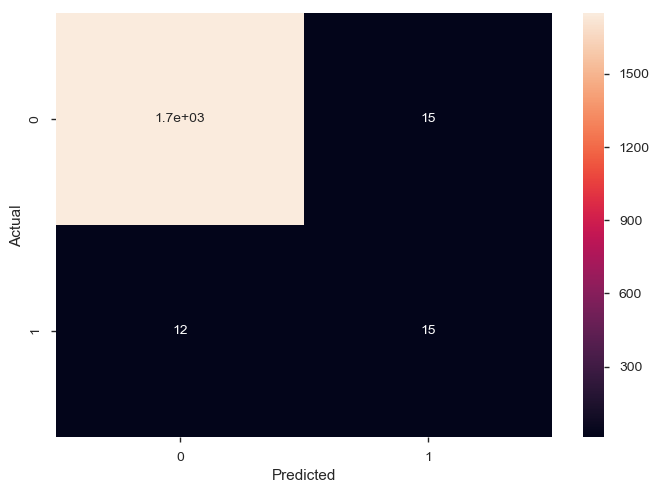

               Training Set Precision Score  Testing Set Precision Score
Imbalanced DF                           1.0                          0.5
               Training Set Recalling Score  Testing Set Rrecalling Score
Imbalanced DF                           1.0                      0.555556


In [14]:
# use the model assess class to output: 1) confusion matrix, 2) precision score, 3) recalling score
imb_mod_assess = model_assess(y_train, y_test, test_pred_imb, train_pred_imb)

# 1)
imb_mod_assess.confusion_matrix()

# 2)
imb_mod_assess.precision_score("Training Set Precision Score", "Testing Set Precision Score", "Imbalanced DF")

# 3)
imb_mod_assess.recalling_score("Training Set Recalling Score", "Testing Set Rrecalling Score", "Imbalanced DF")

We see that both the precision and the recalling score in the training set are near perfect. However, the scores from the testing set indicate that our model with the imbalanced target variable is relatively poor. The test results suggest that the model only correctively identified 56% of the real pulsar stars, and only 50% of the data points our model says relevant were actually relevant. 

### SMOTE Over-Sampling

In [15]:
# SMOTE over-sampling
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train.values.ravel())


In [40]:
# see the sample sizes of each class after resampling

# real pulsar
print("After SMOTE OverSampling, counts of label '1': {}".format(sum(y_train_sm==1)))

# fake pulsar
print("After SMOTE OverSampling, counts of label '0': {}".format(sum(y_train_sm==0)))

After SMOTE OverSampling, counts of label '1': 14497
After SMOTE OverSampling, counts of label '0': 14497


In [41]:
# fit the random forest model
mod.fit(x_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [49]:
# training prediction using random forest
train_pred_smote = mod.predict(x_train_sm)


# testing prediction using random forest
test_pred_smote = mod.predict(x_test)

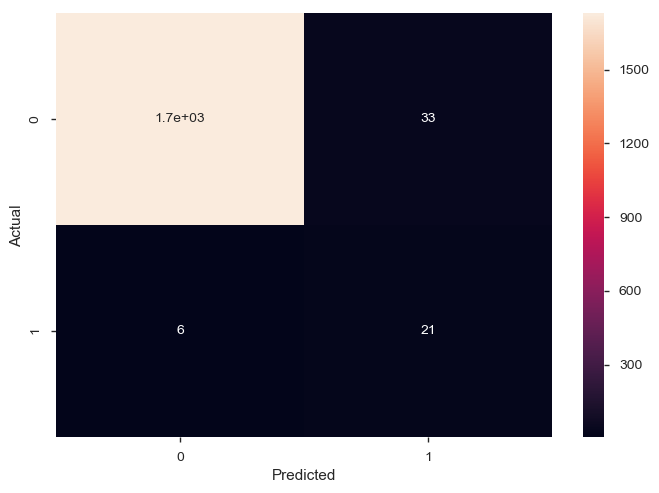

                    Training Set Precision Score  Testing Set Precision Score
SMOTE Resampled DF                           1.0                     0.388889
                    Training Set Recalling Score  Testing Set Rrecalling Score
SMOTE Resampled DF                           1.0                      0.777778


In [50]:
# use the model assess class to output: 1) confusion matrix, 2) precision score, 3) recalling score
sm_mod_assess = model_assess(y_train_sm, y_test, test_pred_smote, train_pred_smote)

# 1)
sm_mod_assess.confusion_matrix()

# 2)
sm_mod_assess.precision_score("Training Set Precision Score", "Testing Set Precision Score", "SMOTE Resampled DF")

# 3)
sm_mod_assess.recalling_score("Training Set Recalling Score", "Testing Set Rrecalling Score", "SMOTE Resampled DF")

Using SMOTE, a recalling score of 0.78 is much better than the previous model with the imbalanced dataset, while the precision score of 0.39 is a little lower. This means that the model correctly identified 78% of the real pulsar stars, and 39% of the data points our model says relevant actually were actually relevant. Also, both the training recalling and precision scores are higher than the scores from the testing scores as expected, but not by too much. 

### The Near Miss Method

In [57]:
# implement near miss resampling method
nm = NearMiss()
x_train_nm, y_train_nm = nm.fit_sample(x_train, y_train.values.ravel())


In [58]:
# check the sample sizes in each class after resampling

# real pulsar
print('After Near Miss Method, counts of label "1": {}'.format(sum(y_train_nm==1)))

# fake pulsar
print('After Near Miss Method, counts of label "0": {}'.format(sum(y_train_nm==0)))

After Near Miss Method, counts of label "1": 1612
After Near Miss Method, counts of label "0": 1612


In [59]:
# fit the random forest model
mod.fit(x_train_nm, y_train_nm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [60]:
# fit training set
train_pred_nm=mod.predict(x_train_nm)

# fit testing set
test_pred_nm = mod.predict(x_test)

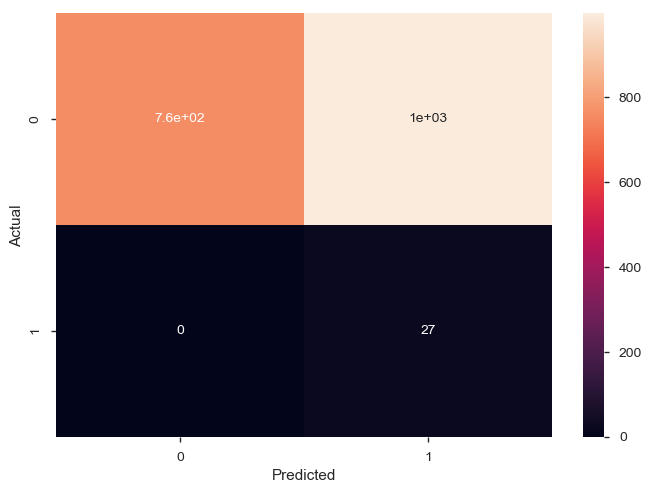

                    Training Set Precision Score  Testing Set Precision Score
SMOTE Resampled DF                           1.0                     0.026341
                    Training Set Recalling Score  Testing Set Rrecalling Score
SMOTE Resampled DF                           1.0                           1.0


In [62]:
# use the model assess class to output: 1) confusion matrix, 2) precision score, 3) recalling score
nm_mod_assess = model_assess(y_train_nm, y_test, test_pred_nm, train_pred_nm)

# 1) 
nm_mod_assess.confusion_matrix()

# 2)
nm_mod_assess.precision_score("Training Set Precision Score", "Testing Set Precision Score", "SMOTE Resampled DF")

# 3)
nm_mod_assess.recalling_score("Training Set Recalling Score", "Testing Set Rrecalling Score", "SMOTE Resampled DF")

Although the recalling score is "perfect", the precison score is very low. We can see from the confusion matrix that about 1000 fake pulsar stars are identified as the true pulsar stars. Comparing to this, the model under the SMOTE method had only 33 fake pulsar stars that are misidentified as the true pulsar stars. Hence, although the recalling score is desirable with the Near Miss method, we would go with the SMOTE method.

### Feature Importance

Since we talked about the colinearity with the feature importance. Let's have a look.

In [32]:
# feature importance
feature_labels = ['Mean of the integrated profile', 'Standard deviation of the integrated profile',
                  'Excess kurtosis of the integrated profile',
                  'Skewness of the integrated profile',
                  'Mean of the DM-SNR curve',
                  'Standard deviation of the DM-SNR curve',
                  'Excess kurtosis of the DM-SNR curve',
                  'Skewness of the DM-SNR curve'] 

for feature in zip(feature_labels, mod.feature_importances_):
    print(feature)

('Mean of the integrated profile', 0.19042872079213163)
('Standard deviation of the integrated profile', 0.03415281725846247)
('Excess kurtosis of the integrated profile', 0.30670815405524116)
('Skewness of the integrated profile', 0.1697273675428853)
('Mean of the DM-SNR curve', 0.0838368705656048)
('Standard deviation of the DM-SNR curve', 0.1086706489255201)
('Excess kurtosis of the DM-SNR curve', 0.04651717377515345)
('Skewness of the DM-SNR curve', 0.0599582470850008)


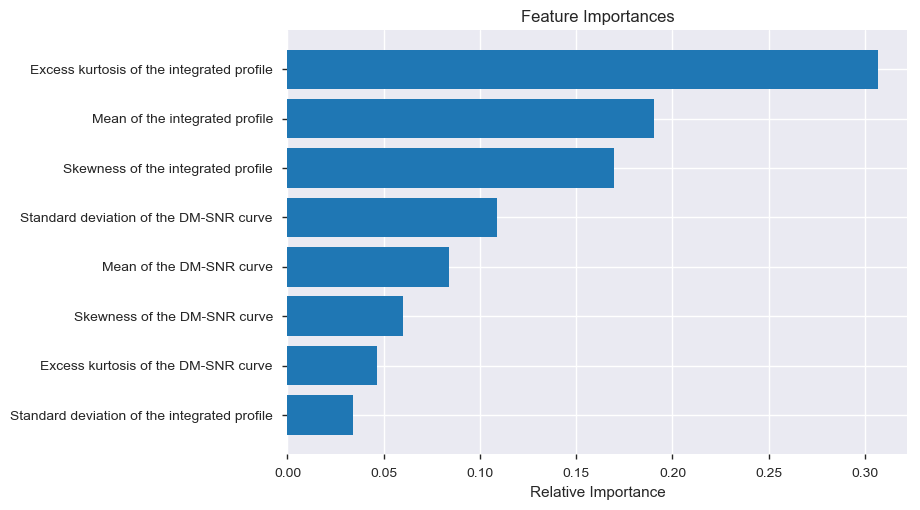

In [34]:
# see feature importance

importances = mod.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_labels[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()